In [1]:
# Install Packages

import numpy as np
from scipy import stats
import pylab as plt
import torch
import pytorch_lightning as pl
import swyft
import matplotlib.pyplot as plt
%pylab inline
import scipy
import time
import seaborn as sns
plt.rc("text", usetex=True)
plt.rc("font", family="Serif")
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

In [43]:
# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4076
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #omega
                                                stats.uniform(0,3)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [44]:
# Sample from Simulator

n_samples = 10_000
fref = 10
CE_PSD = np.genfromtxt("../Abby/data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("../Abby/data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
sims = sim.sample(N = n_samples)

sims['x'] = np.log10(np.abs(sims['x']))
# Standardize data!
mu_f = np.mean(sims['x'], axis=0)
sigma_f = np.std(sims['x'], axis=0)
sims['x'] = (sims['x']-mu_f)/sigma_f


100%|██████████| 10000/10000 [00:38<00:00, 257.89it/s]


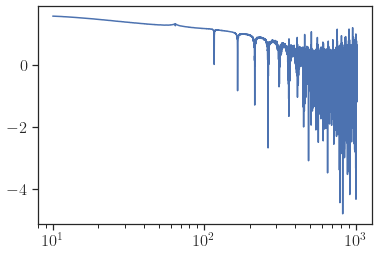

In [45]:
plt.semilogx(sim.freq, sims['x'][1])

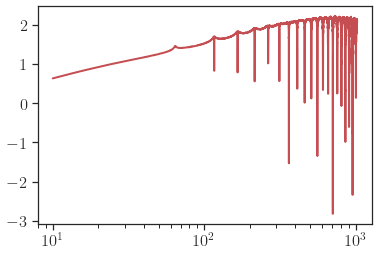

In [46]:
samples = swyft.Samples(x=sims['x'][1:], z=sims['z'][1:]) # Samples for training network
obs = swyft.Sample(x=sims['x'][0], z=sims['z'][0] ) # Example observation for inference

# Set aside observation parameters for later
obs_omega = sims['z'][0][0]
obs_alpha = sims['z'][0][1]

# Plot example observation
plt.semilogx(sim.freq, obs['x'], 'r', lw=2)

In [47]:
# Define swyft network

import torch.nn as nn
import torch.nn.functional as F

class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # VAE
        self.summarizer =  nn.Sequential(
            nn.Linear(4076, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
            nn.Linear(16, 2),
  
        )
        
#             self.dropout(self.reparameterize(self.encode(x)))
#            mu, logvar = self.encode(x)
#            z = self.reparameterize(mu, logvar)
#            z = self.dropout(z)

        # Log-ratio estimator with 1 feature (x) and 2 parameters (alpha, omega)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=1,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z',  # Names of the parameters
            # Number of neural network blocks
        )

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z']), s

In [ ]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples, batch_size=32)

# Step 5: Instantiate and train the network
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 11.1 M
1 | logratios  | LogRatioEstimator_1dim | 34.8 K
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
89.251    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 250/313 [02:48<00:42,  1.48it/s, loss=-1.33, v_num=4] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 250/313 [02:56<00:44,  1.42it/s, loss=-1.59, v_num=4, val_loss=-1.21]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 250/313 [02:59<00:45,  1.39it/s, loss=-1.69, v_num=4, val_loss=-1.37]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 250/313 [03:01<00:45,  1.37it/s, loss=-1.84, v_num=4, val_loss=-1.31]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 250/313 [02:50<00:42,  1.47it/s, loss=-1.9, v_num=4, val_loss=-1.52] 
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 250/313 [00:57<00:14,  4.31it/s, loss=-1.92, v_num=4, val_loss=-1.50]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 250/313 [00:28<00:07,  8.87it/s, loss=-1.98, v_num=4, val_loss=-1.30]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 250/313 [00:26<00:06,  9.38it/s, loss=-1.88, v_num=4, val_loss=-1.44]
Validation: 0it [00:00, ?it/s]

In [70]:
idx = 18
obs = swyft.Sample(x=sims['x'][idx], z=sims['z'][idx]) # Example observation for inference
print("Injected parameters:", obs['z'])

Injected parameters: [-8.1230345  2.6472192]


In [68]:
# Define priors
omega_prior = stats.uniform(-12, 5)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 3)            # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


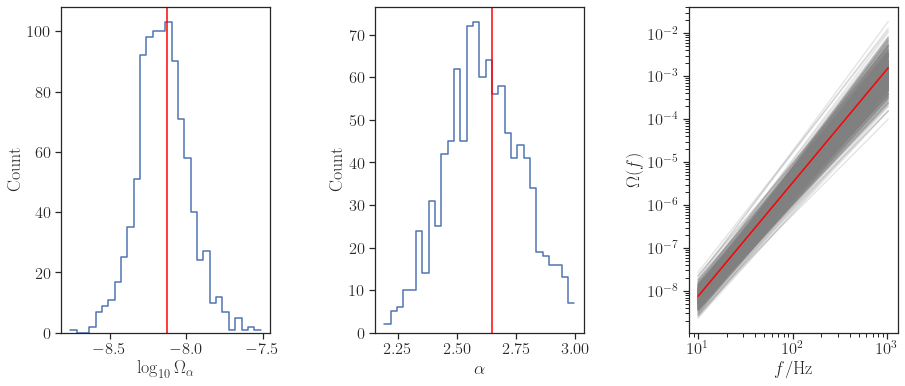

In [78]:
ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(obs['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(obs['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")